In [16]:
from cytoflow import *
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
import tqdm
import iteration_utilities

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", { "xtick.major.size": 4, "ytick.major.size": 4, "font_color":'k', 'axes.edgecolor': 'k', 'xtick.color': 'k', 'ytick.color': 'k'})
sns.set_context("talk", font_scale=1.0)

# Loading Tubes

## Defining the tube-loading function

Copy this for future reference

In [17]:
plasmid_dict = { # maps plasmid number => plasmid name 
    1260 : "rTetR only",
    78 : "Ctrl - Ctrl",
    1440 : "MYBA only",
    80 : "BIN1 - FOXO3",
    141 : "BIN1 - Ctrl",
    142 : "Ctrl - FOXO3",
    92 : "SMCA2 - U2AF4",
    144 : "SMCA2 - Ctrl",
    131 : "U2AF4 - Ctrl",
    134 : "MYBA - ZN473",
    133 : "MYBA - Ctrl",
    135 : "Ctrl - ZN473",
    125 : "BTK - ABL1",
    129 : "BTK - Ctrl",
    130 : "Ctrl - ABL1",
    126 : "U2AF4 - BTK",
    127 : "BTK - WWP2",
    132 : "CTRL - WWP2",
    79 : "ANM2 - KIBRA",
    136 : "ANM2 - Ctrl",
    138 : "KIBRA - Ctrl",
    90 : "NOTC2 - ANM2",
    91 : "NOTC2 - KIBRA",
    157 : "NOTC2 - Ctrl"
}

plasmid_numbers = sorted(list(plasmid_dict.keys()))
plasmid_names = [plasmid_dict[p] for p in plasmid_numbers]

In [18]:
days = [0, 1, 2]
replicates = [1, 2]

In [19]:
letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

def get_tube_location(day, plasmid, replicate):
    layout = [
        [1260, 78, 1440, 80, 141, 142],
        [ 92, 144, 131, 134, 133, 135],
        [125, 129, 130, 126, 127, 132],
        [ 79, 136, 138,  90,  91, 157]
    ]
    
    for row in layout:
        if plasmid in row:
            r = layout.index(row) + 4 * (1 - replicate) # get row
            c = row.index(plasmid) + 6 * (day // 2) # get col
            return letters[r] + str(numbers[c])

def get_tube_file(day, plasmid, replicate):
    # first, get folder location
    filedir = './fcs'
    if day == 0:
        filedir = filedir + '/axm-20220303_actsyn_0dox-20220303-1555/'
    else:
        filedir = filedir + '/axm-20220303_actsyn_dox-20220303-1617/'
    tubename = get_tube_location(day, plasmid, replicate)
    return filedir + tubename + '.fcs'

## Here we go

In [38]:
tubeslist = []

for day in [0, 1, 2]:
    for plasmid in plasmid_dict:
        for replicate in [1, 2]:
#             print(day, plasmid, replicate)
            tubeslist.extend([
                Tube(conditions = {'plasmid' : plasmid,
                                   'description' : plasmid_dict[plasmid],
                                   'day' : day,
                                   'replicate' : replicate},
                    file = get_tube_file(day, plasmid, replicate),
                    conditions_list = ['plasmid', 'description', 'day', 'replicate'])])

print("Loaded", len(tubeslist), "tubes")

Loaded 144 tubes


In [39]:
get_tube_file(1, 138, 2)

'./fcs/axm-20220303_actsyn_dox-20220303-1617/H3.fcs'

# Import

In [40]:
tqdm.tqdm_notebook()

<ipython-input-40-27297fd6e26f>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [41]:
%%time

tls = tubeslist

def get_ex0(chunk):
    op0 = ImportOp(
        conditions = {'plasmid'     : 'category',
                      'description' : 'category',
                      'day'         : 'float',
                      'replicate'   : 'float'},
        tubes = chunk,
        channels={'mCitrine-A':'mCitrine-A',
                  'mCherry-A':'mCherry-A',
                  'FSC 488/10-A':'FSC 488/10-A',
                  'SSC 488/10-A':'SSC 488/10-A'})
    ex0 = op0.apply()
    return ex0


ex0_list = [get_ex0(list(chunk))  
            for chunk in tqdm.notebook.tqdm_notebook(iteration_utilities.grouper(tls, 1), 
                                            position = 0, leave = True, total = len(tls))]

ex0 = ex0_list[0]
all_data = pd.concat([e.data for e in tqdm.notebook.tqdm(ex0_list)])
ex0.data = all_data
ex0.data.head()

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

CPU times: user 6.87 s, sys: 394 ms, total: 7.27 s
Wall time: 7.41 s


,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate
0,357657344.0,130077184.0,0.0,rTetR only,214476800.0,935936.0,1260,1.0
1,613253888.0,186921472.0,0.0,rTetR only,88771328.0,1988608.0,1260,1.0
2,409882368.0,184542208.0,0.0,rTetR only,340477184.0,2286848.0,1260,1.0
3,438074880.0,229615616.0,0.0,rTetR only,140216320.0,2050560.0,1260,1.0
4,550200064.0,295275008.0,0.0,rTetR only,163602944.0,2893824.0,1260,1.0


# Gate for live cells

CPU times: user 21.1 s, sys: 1.46 s, total: 22.6 s
Wall time: 9 s


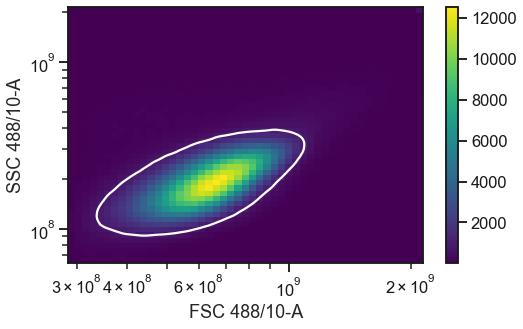

In [42]:
%%time

dens_op = DensityGateOp(
    name = 'P1',
    xchannel='FSC 488/10-A',
    xscale = 'log',
    ychannel='SSC 488/10-A',
    yscale = 'log',
    keep = 0.9)

dens_op.estimate(ex0)
ex1 = dens_op.apply(ex0)
dens_op.default_view().plot(ex0, height = 5)

In [43]:
ex1.data.groupby('P1').size()

P1
False     120905
True     1564840
dtype: int64

In [44]:
edf = ex1.data
all_data[all_data['plasmid']==138]

,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate
0,5.174733e+08,183806720.0,0.0,KIBRA - Ctrl,142389248.0,1900288.0,138,1.0
1,6.622164e+08,238872320.0,0.0,KIBRA - Ctrl,208458496.0,2371840.0,138,1.0
2,6.309066e+08,288128512.0,0.0,KIBRA - Ctrl,113195776.0,2787840.0,138,1.0
3,5.067402e+08,192910080.0,0.0,KIBRA - Ctrl,175829504.0,3108096.0,138,1.0
4,7.010967e+08,292076544.0,0.0,KIBRA - Ctrl,358389248.0,2453504.0,138,1.0
...,...,...,...,...,...,...,...,...
12628,4.854339e+08,115119872.0,2.0,KIBRA - Ctrl,258048256.0,1196288.0,138,2.0
12629,1.009637e+09,238825216.0,2.0,KIBRA - Ctrl,102774528.0,2065664.0,138,2.0
12630,5.384136e+08,110054912.0,2.0,KIBRA - Ctrl,127019776.0,1971712.0,138,2.0
12631,4.344074e+08,96544512.0,2.0,KIBRA - Ctrl,8364032.0,3684864.0,138,2.0


# Gate on mCherry

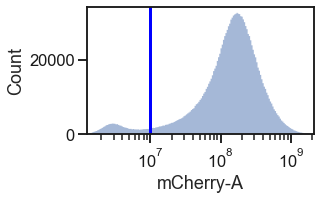

In [45]:
op_2 = ThresholdOp(
    name='mCherry', threshold=1e7, channel='mCherry-A')
ex_2 = op_2.apply(ex1)
op_2.default_view(
    subset='(P1==True)', scale='log').plot(ex_2)

# Export data

In [46]:
ex_2.data.to_csv('./data/all_cells_live_mch_gated.csv', index = False)